# Stock Market News Analysis
# 
# This notebook analyzes stock market news sentiment and correlates it with stock price movements.


# Configuration


In [1]:
# Configuration parameters for analysis
CONFIG = {
    # Stock symbol to analyze (e.g., "AAPL", "MSFT", "GOOGL", "MRK")
    "stock_symbol": "MRK",
    
    # Analysis year (e.g., 2018, 2019, 2020)
    "analysis_year": 2019,
    
    # Date for company details (format: "YYYY-MM-DD")
    "company_details_date": "2025-07-07",
    
    # File paths
    "news_data_path": "news_data.csv",
    "output_news_data_path": "news_data_updated.csv",
    
    # Output file names
    "wordcloud_output": "wordcloud_tickers.png",
    "sentiment_trends_output": "sentiment_trends_grouped.png",
    "company_sentiment_output": "{stock_symbol}_sentiment_analysis.png",
    "stock_candlestick_output": "{stock_symbol}_{year}_candlestick.png",
    "stock_closing_price_output": "{stock_symbol}_{year}_closing_price.png",
    "sentiment_with_stock_price_output": "{stock_symbol}_{year}_sentiment_with_stock_price.png"
}


# Import Package And Dependencies


In [2]:
# !pip install requests
# !pip install --upgrade yfinance
# !pip install pandas
# !pip install nltk
# !pip install spacy
# !pip install matplotlib
# !pip install wordcloud
# !pip install vaderSentiment
# !pip install mplfinance


In [3]:
# Standard library imports
import re
import json
import traceback
from typing import Any, Optional, List, Union, Dict

# Data processing imports
import pandas as pd
import numpy as np

# NLP imports
import nltk
import spacy
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Visualization imports
import matplotlib.pyplot as plt
import mplfinance as mpf

# Financial data imports
import yfinance as yf


In [4]:
# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)


# Load DATASET into Pandas Dataframe


In [5]:
# https://www.kaggle.com/datasets/hkapoor/indian-financial-news-articles-20032020


In [6]:
def save_news_dataframe(df: pd.DataFrame, file_path: str = CONFIG["output_news_data_path"]) -> bool:
    """
    Saves the news DataFrame to a CSV file.

    Args:
        df (pd.DataFrame): The DataFrame to save.
        file_path (str): The path to the CSV file.

    Returns:
        bool: True if the save was successful, False otherwise.
    """
    try:
        df.to_csv(file_path, index=False)
        print(f"News DataFrame saved to {file_path}")
        return True
    except Exception as e:
        print(f"Error: Failed to save news DataFrame: {e}")
        return False


In [7]:
def load_and_explore_data(file_path: str = CONFIG["news_data_path"]) -> Optional[pd.DataFrame]:
    """
    Loads the dataset and performs initial exploration.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        Optional[pd.DataFrame]: The loaded DataFrame, or None if an error occurs.
    """
    try:
        # Load the dataset
        df = pd.read_csv(file_path)
        print("Data loaded successfully.")

        # Display the first 5 rows
        print("\n--- First 5 rows ---")
        print(df.head())

        # Display DataFrame info
        print("\n\n--- DataFrame Info ---")
        print(df.info())

        # Display DataFrame description
        print("\n\n--- DataFrame Description ---")
        print(df.describe())

        # Preprocess the data
        df = df[['title', 'date', 'stock']].drop_duplicates()
        df = df.dropna()  # Assign the result back to df

        try:
            df['Date'] = pd.to_datetime(df['date'], format='mixed', utc=True)
        except Exception as e:
            print(f"Error converting dates: {e}")
            # Try a more robust approach with error handling for problematic values
            df['Date'] = pd.to_datetime(df['date'], format='mixed', utc=True, errors='coerce')
            # Drop rows with NaT (Not a Time) values if any
            df = df.dropna(subset=['Date'])

        df['Year'] = df['Date'].dt.year

        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: File at {file_path} is empty")
        return None
    except pd.errors.ParserError as e:
        print(f"Error: Failed to parse file at {file_path}: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [8]:
# Load the dataset
news_df = load_and_explore_data()

if news_df is None:
    exit()  # Stop execution if data loading fails

# news_df = news_df.sample(n=len(news_df))
# news_df = news_df.iloc[:1000,:]


Data loaded successfully.

--- First 5 rows ---
   Unnamed: 0                                              title                       date stock
0         0.0            Stocks That Hit 52-Week Highs On Friday  2020-06-05 10:30:00-04:00     A
1         1.0         Stocks That Hit 52-Week Highs On Wednesday  2020-06-03 10:45:00-04:00     A
2         2.0                      71 Biggest Movers From Friday  2020-05-26 04:30:00-04:00     A
3         3.0       46 Stocks Moving In Friday's Mid-Day Session  2020-05-22 12:45:00-04:00     A
4         4.0  B of A Securities Maintains Neutral on Agilent...  2020-05-22 11:38:00-04:00     A


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400469 entries, 0 to 1400468
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1399180 non-null  float64
 1   title       1400469 non-null  object 
 2   date        1399180 non-null  object 
 3   stock  

In [9]:
def get_company_details(stock_symbol: str = CONFIG["stock_symbol"], 
                       date_str: str = CONFIG["company_details_date"]) -> None:
    """
    Fetches and prints company details and historical market data for a given
    stock symbol and date using the yfinance library.

    Args:
        stock_symbol (str): The stock ticker symbol (e.g., 'MSFT', 'GOOGL').
        date_str (str): The date in 'YYYY-MM-DD' format.
    """
    print(f"\n--- Fetching details for {stock_symbol} on {date_str} ---")
    try:
        # Create a Ticker object for the stock symbol
        ticker = yf.Ticker(stock_symbol)

        # 1. Get the general company information (a dictionary)
        info = ticker.info

        # Check if the ticker is valid by looking for a key like 'longName'
        if 'longName' not in info:
            print(f"Could not find company details for symbol: {stock_symbol}")
            return

        print(f"Company Info: {json.dumps(info)}")
        print(f"Company Name: {info.get('longName', 'N/A')}")
        print(f"Sector: {info.get('sector', 'N/A')}")
        print(f"Industry: {info.get('industry', 'N/A')}")
        print(f"Website: {info.get('website', 'N/A')}")

        # 2. Get historical market data for the specific date
        # To get a single day, set the end date to the next day
        start_date = date_str
        end_date = (pd.to_datetime(date_str) + pd.Timedelta(days=1)).strftime('%Y-%m-%d')

        hist_data = ticker.history(start=start_date, end=end_date)

        if hist_data.empty:
            print(f"\nNo market data found for {date_str}. It might be a weekend or holiday.")
        else:
            # Extract the data for our specific date
            day_data = hist_data.iloc[0]
            print("\nMarket Data for the Day:")
            print(f"  Open:   ${day_data['Open']:.2f}")
            print(f"  High:   ${day_data['High']:.2f}")
            print(f"  Low:    ${day_data['Low']:.2f}")
            print(f"  Close:  ${day_data['Close']:.2f}")
            print(f"  Volume: {day_data['Volume']:,}")

    except Exception as e:
        print(f"An error occurred while fetching data: {e}")

# Get details for the configured stock on the specified date
get_company_details()



--- Fetching details for MRK on 2025-07-07 ---
Company Info: {"address1": "126 East Lincoln Avenue", "city": "Rahway", "state": "NJ", "zip": "07065", "country": "United States", "phone": "908 740 4000", "website": "https://www.merck.com", "industry": "Drug Manufacturers - General", "industryKey": "drug-manufacturers-general", "industryDisp": "Drug Manufacturers - General", "sector": "Healthcare", "sectorKey": "healthcare", "sectorDisp": "Healthcare", "longBusinessSummary": "Merck & Co., Inc. operates as a healthcare company worldwide. It operates through two segments, Pharmaceutical and Animal Health. The company offers human health pharmaceutical for various areas, including oncology, vaccines, hospital acute care, cardiovascular, virology, neuroscience, and diabetes under the Keytruda, Welireg, Gardasil, ProQuad, M-M-R II, Varivax, Vaxneuvance, RotaTeq, Pneumovax 23, Bridion, Dificid, Zerbaxa, Noxafil, Winrevair, Adempas, Verquvo, Lagevrio, Isentress/Isentress HD, Delstrigo, Pifeltr

# Initialize NLP Components


In [10]:
# Initialize sentiment intensity analyzer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package punkt to /Users/sandy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sandy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sandy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

# Initialize spaCy model for company name extraction
nlp = spacy.load('en_core_web_sm')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.8 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Text Processing Operations


In [12]:
def clean_text(text: Union[str, Any]) -> str:
    """
    Cleans the text by converting to lowercase and removing special characters and digits.

    This function performs the following operations:
    1. Converts input to string
    2. Removes punctuation except periods
    3. Converts to lowercase
    4. Replaces periods with underscores (to keep ticker symbols as single words)
    5. Removes possessive 's
    6. Removes special characters and digits, but keeps underscores

    Args:
        text (Union[str, Any]): The text to clean. Can be any type that can be converted to string.

    Returns:
        str: The cleaned text.
    """
    if text is None:
        return ""

    # Convert to string if not already
    text = str(text)

    # Remove punctuation except periods
    text = re.sub(r'[^\w\s.]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Replace periods with underscores to keep ticker symbols as single words
    text = text.replace('.', '_')

    # Remove possessive 's
    text = text.replace("'s", '')

    # Remove special characters and digits, but keep underscores
    text = re.sub(r'[^a-zA-Z\s_]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [13]:
def analyze_sentiment(description: Optional[str]) -> str:
    """
    Analyzes the sentiment of the given text using NLTK's VADER sentiment analysis.

    This function uses the VADER (Valence Aware Dictionary and sEntiment Reasoner) 
    sentiment analysis tool from NLTK to determine if the text has a positive, 
    negative, or neutral sentiment.

    The sentiment is determined based on the compound score:
    - Positive: compound score >= 0.05
    - Negative: compound score <= -0.05
    - Neutral: compound score between -0.05 and 0.05

    Args:
        description (Optional[str]): The text to analyze. Can be None.

    Returns:
        str: The sentiment label ('Positive', 'Negative', 'Neutral', or 'Unknown' if an error occurs).
    """
    if not description:
        return 'Unknown'

    try:
        # Clean the text before analysis
        cleaned_description = clean_text(description)

        # Skip empty strings after cleaning
        if not cleaned_description:
            return 'Unknown'

        # Get sentiment scores
        sentiment_scores = sia.polarity_scores(cleaned_description)
        compound_score = sentiment_scores['compound']

        # Determine sentiment based on compound score
        if compound_score >= 0.05:
            return 'Positive'
        elif compound_score <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    except Exception as e:
        print(f"Error analyzing sentiment for text '{description[:50]}...': {e}")
        return 'Unknown'


In [14]:
# Apply sentiment analysis to the news titles
news_df['Sentiment'] = news_df['title'].apply(analyze_sentiment)


# Finding Company which is mostly coming up in News using Word Cloud


In [15]:
def generate_word_cloud(company_names: Union[List, np.ndarray, pd.Series, str], 
                     output_file: str = CONFIG["wordcloud_output"],
                     apply_nlp_processing: bool = False) -> None:
    """
    Generates a word cloud from company names or text.

    This function takes a collection of company names or text, processes it,
    and generates a word cloud visualization that highlights the most frequent terms.

    Args:
        company_names (Union[List, np.ndarray, pd.Series, str]): 
            The company names or text to visualize. Can be a list, numpy array, pandas Series, or string.
        output_file (str): 
            The name of the file to save the word cloud to.
        apply_nlp_processing (bool):
            Whether to apply NLP processing (tokenization, stopword removal, lemmatization).
            Default is False.

    Returns:
        None: The function saves the word cloud to a file and displays it.
    """
    print(f"Input type: {type(company_names)}")

    # Process the input based on its type
    if isinstance(company_names, (list, np.ndarray)):
        # Remove None values and convert all items to strings
        names_list = [str(name) for name in company_names if name is not None]
        # Remove duplicates by converting to a set first, then back to a list
        unique_names = list(set(names_list))
        text = ' '.join(unique_names)
    elif isinstance(company_names, pd.Series):
        # Convert Series to list, remove None values, and join
        names_list = [str(name) for name in company_names.tolist() if name is not None]
        unique_names = list(set(names_list))
        text = ' '.join(unique_names)
    else:
        # If it's already a string or another type, convert to string
        text = str(company_names)

    # Apply NLP processing if requested
    if apply_nlp_processing:
        # Tokenize text
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.lower() not in stop_words]

        # Lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back into a string
        text = ' '.join(tokens)

    # Print a preview of the processed text
    print("Processed text for wordcloud:", text[:100] + "..." if len(text) > 100 else text)

    # Check if text is empty
    if not text.strip():
        print("Warning: No text to generate word cloud from.")
        return

    try:
        # Create a word cloud
        wordcloud = WordCloud(
            width=1000,
            height=500,
            max_font_size=100,
            max_words=200,
            background_color='white',
            colormap='viridis',
            collocations=False  # Avoid repeating word pairs
        ).generate(text)

        # Plot the word cloud
        plt.figure(figsize=(10, 8))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Company Names', fontsize=15)
        plt.tight_layout(pad=0)
        plt.show()
        plt.close()

        # Save the word cloud to a file
        wordcloud.to_file(output_file)
        print(f"\nWord cloud saved to {output_file}")

        # Print the top 10 words in the word cloud
        print("Top 10 words in the word cloud:")
        sorted_words = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)[:10]
        for word, frequency in sorted_words:
            print(f"{word}: {frequency:.4f}")

    except Exception as e:
        print(f"Error generating word cloud: {e}")


Input type: <class 'numpy.ndarray'>
Processed text for wordcloud: COF MGPI TNGO BIOC X EMCG NBL EIG SWK AET MIFI PAGG SMRT LRE STRL NBG AXR CNHI LBY FRSH UPS QDXU KND...


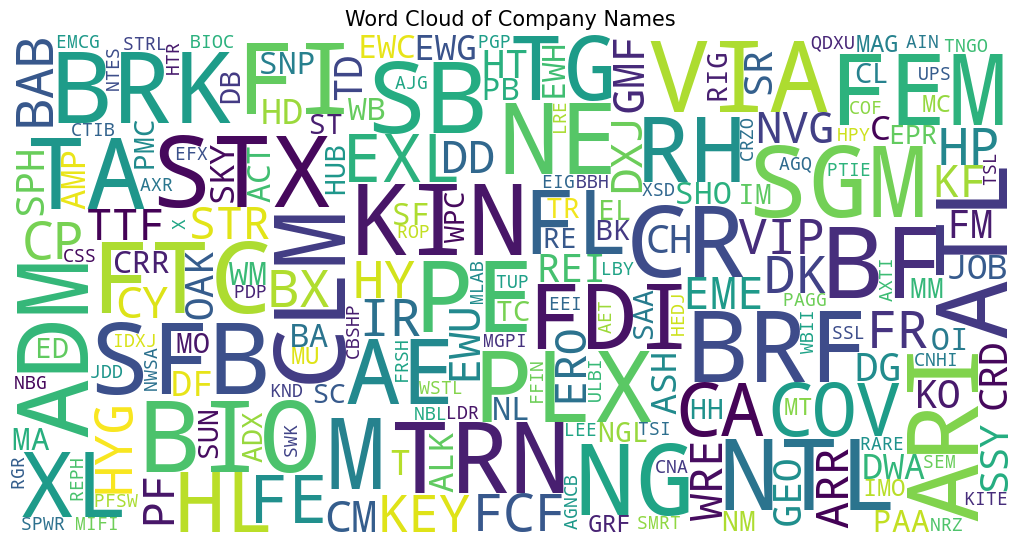


Word cloud saved to wordcloud_tickers.png
Top 10 words in the word cloud:
BIO: 1.0000
NE: 1.0000
CLM: 1.0000
CR: 1.0000
PLX: 1.0000
PE: 1.0000
TA: 1.0000
SGM: 1.0000
BF: 1.0000
FI: 1.0000


In [16]:
# Generate and save the word cloud
generate_word_cloud(news_df['stock'].values)


In [17]:
# Display the most frequent stock symbols in the news
print(news_df['stock'].value_counts())


stock
MRK      3327
MS       3217
MU       3142
NVDA     3129
QQQ      3098
M        3065
EBAY     3018
NFLX     3009
GILD     2964
VZ       2937
DAL      2927
JNJ      2925
QCOM     2914
BABA     2819
KO       2778
ORCL     2690
FDX      2624
HD       2613
WFC      2612
BBRY     2570
BMY      2513
JCP      2496
AGN      2398
LLY      2398
CMG      2364
CAT      2297
GPRO     2292
TWX      2271
CHK      2263
FSLR     2228
P        2215
MCD      2208
NOK      2208
LMT      2201
MA       2172
EA       2164
FCX      2158
EWU      2149
GPS      2128
PEP      2122
XLF      2111
GRPN     2092
TM       2053
GLD      2031
EWP      2026
HAL      2018
LOW      2009
XRT      1994
ADBE     1991
AZN      1988
MYL      1980
DISH     1973
ATVI     1945
TSLA     1929
MDT      1923
DB       1916
LNKD     1906
EWI      1901
BIIB     1899
BIDU     1886
DE       1861
CMCSA    1848
CVS      1844
AXP      1842
WDC      1821
A        1807
PFE      1798
BAC      1796
RIG      1792
MON      1790
KR       1788


In [18]:
# Get the top stock symbols
top_n = 1  # Number of top stocks to analyze
top_stocks = news_df['stock'].value_counts().index[:top_n].tolist()

print(f"Top {top_n} stocks: {top_stocks}")


Top 1 stocks: ['MRK']


# Year wise Sentiment Analysis Visualization


In [19]:
def analyze_and_visualize_sentiment_by_year(news_df: pd.DataFrame, 
                                    output_file: str = CONFIG["sentiment_trends_output"]) -> None:
    """
    Analyzes sentiment trends over time (by year) and visualizes the results
    using a grouped bar chart.

    This function processes the news DataFrame to extract sentiment trends over time,
    and creates a visualization showing how sentiment distribution changes by year.

    Args:
        news_df (pd.DataFrame): The DataFrame containing news data.
        output_file (str): The path to save the visualization image.

    Returns:
        None: The function saves the visualization to a file and displays it.
    """
    try:
        # Make a copy to avoid modifying the original DataFrame
        df = news_df.copy()

        # Convert the Date column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'], format='mixed', errors='coerce')
            # Drop rows with invalid dates
            df = df.dropna(subset=['Date'])

        if df.empty:
            print("Error: No valid data after date conversion.")
            return

        # Extract the year and month from the Date column
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month

        # Group the data by year and month, and count the number of negative, neutral, and positive sentiments
        df_grouped = df.groupby(['Year', 'Month', 'Sentiment']).size().reset_index(name='Count')

        # Pivot the data to create a table with year and month on the x-axis, and sentiment counts as values
        df_pivot = df_grouped.pivot_table(index=['Year', 'Month'], columns='Sentiment', values='Count').fillna(0)

        # --- Plotting ---
        # Create a yearly pivot table for the bar chart
        df_pivot_yearly = df.groupby('Year')['Sentiment'].value_counts().unstack().fillna(0)

        # Check if we have data to plot
        if df_pivot_yearly.empty:
            print("Error: No data to plot after grouping.")
            return

        # Set up the figure
        plt.figure(figsize=(15, 8))

        # Define colors for different sentiments with better contrast
        colors = {
            'Negative': '#E53935',  # Bright red
            'Neutral': '#1E88E5',   # Bright blue
            'Positive': '#43A047'   # Bright green
        }

        # Get the available sentiment columns and their corresponding colors
        available_sentiments = df_pivot_yearly.columns.tolist()
        plot_colors = [colors.get(sentiment, '#9E9E9E') for sentiment in available_sentiments]

        # Create the bar chart
        ax = df_pivot_yearly.plot(
            kind='bar', 
            figsize=(15, 8), 
            color=plot_colors,
            width=0.8
        )

        # Add data labels on top of each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', fontsize=10)

        # Add a grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add labels and title
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Number of News Articles', fontsize=12)
        plt.title(f'Sentiment Analysis: {len(df.index)} News Articles ({df['Year'].min()}-{df['Year'].max()})', 
                 fontsize=14, fontweight='bold')

        # Improve legend
        plt.legend(title='Sentiment', fontsize=10, title_fontsize=12)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_file}")

        # Show the plot
        plt.show()
        plt.close()

        # Print summary statistics
        print("\nSentiment Distribution by Year:")
        print(df_pivot_yearly)

    except Exception as e:
        print(f"Error in sentiment analysis visualization: {e}")


Visualization saved to sentiment_trends_grouped.png


<Figure size 1500x800 with 0 Axes>

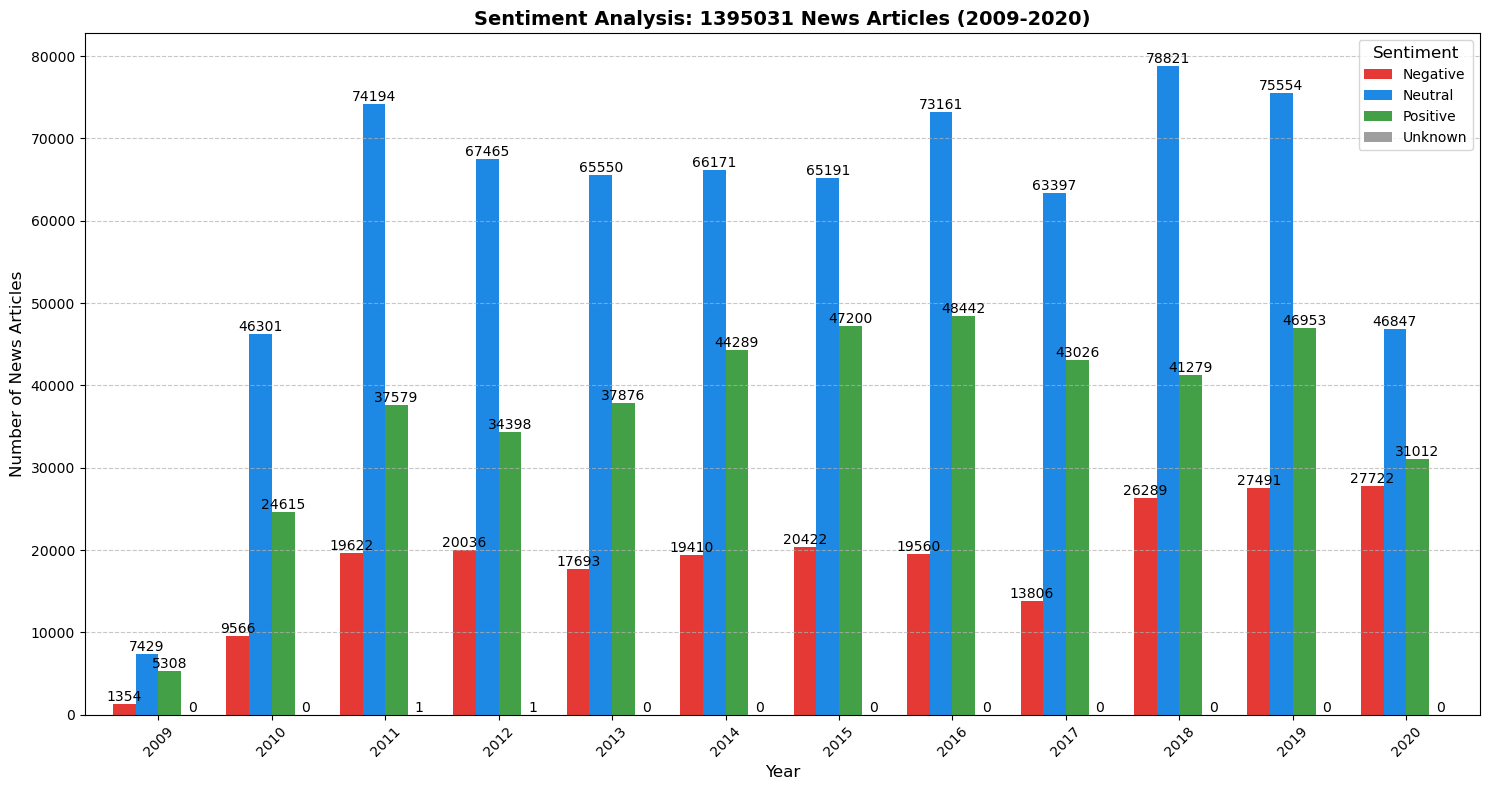


Sentiment Distribution by Year:
Sentiment  Negative  Neutral  Positive  Unknown
Year                                           
2009         1354.0   7429.0    5308.0      0.0
2010         9566.0  46301.0   24615.0      0.0
2011        19622.0  74194.0   37579.0      1.0
2012        20036.0  67465.0   34398.0      1.0
2013        17693.0  65550.0   37876.0      0.0
2014        19410.0  66171.0   44289.0      0.0
2015        20422.0  65191.0   47200.0      0.0
2016        19560.0  73161.0   48442.0      0.0
2017        13806.0  63397.0   43026.0      0.0
2018        26289.0  78821.0   41279.0      0.0
2019        27491.0  75554.0   46953.0      0.0
2020        27722.0  46847.0   31012.0      0.0


In [20]:
# Analyze and visualize sentiment trends by year
analyze_and_visualize_sentiment_by_year(news_df)


# Company Specific Sentiment Analysis


In [21]:
def analyze_and_visualize_company_sentiment(company_name: str, news_df: pd.DataFrame, 
                                    output_prefix: str = None) -> None:
    """
    Filters the dataset for a specific company, analyzes sentiment, and visualizes
    the results using multiple charts.

    This function analyzes sentiment trends for a specific company over time and
    creates visualizations to show the distribution and trends of sentiment.

    Args:
        company_name (str): The name or ticker symbol of the company to analyze.
        news_df (pd.DataFrame): The DataFrame containing news data.
        output_prefix (str, optional): Prefix for output files. If None, uses company_name.

    Returns:
        None: The function displays visualizations and saves them to files.
    """
    if output_prefix is None:
        output_prefix = company_name

    try:
        # Filter the dataset for the specific company
        company_df = news_df[news_df['stock'] == company_name].copy()

        if company_df.empty:
            print(f"No data found for company with ticker symbol '{company_name}'")
            return

        # Convert the Date column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(company_df['Date']):
            company_df['Date'] = pd.to_datetime(company_df['Date'], format='mixed', errors='coerce')
            # Drop rows with invalid dates
            company_df = company_df.dropna(subset=['Date'])

        if company_df.empty:
            print(f"No valid data after date conversion for company '{company_name}'")
            return

        # Extract year and month
        company_df['Year'] = company_df['Date'].dt.year
        company_df['Month'] = company_df['Date'].dt.month

        # Count the number of positive, negative, and neutral sentiments for the company
        sentiment_counts = company_df['Sentiment'].value_counts()
        positive_count = sentiment_counts.get('Positive', 0)
        negative_count = sentiment_counts.get('Negative', 0)
        neutral_count = sentiment_counts.get('Neutral', 0)
        total_count = positive_count + negative_count + neutral_count

        # Print the counts and percentages
        print(f"\n--- Sentiment Analysis for {company_name} ---")
        print(f"Total articles: {total_count}")
        print(f"Positive: {positive_count} ({positive_count/total_count*100:.1f}%)")
        print(f"Negative: {negative_count} ({negative_count/total_count*100:.1f}%)")
        print(f"Neutral: {neutral_count} ({neutral_count/total_count*100:.1f}%)")

        # Create a figure with 2 subplots: pie chart and line chart
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # 1. Pie Chart - Sentiment Distribution
        labels = ['Positive', 'Negative', 'Neutral']
        sizes = [positive_count, negative_count, neutral_count]
        colors = ['#43A047', '#E53935', '#1E88E5']  # Green, Red, Blue
        explode = (0.1, 0.1, 0.1)  # Explode all slices for better visibility

        ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=90, textprops={'fontsize': 12})
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        ax1.set_title(f'Sentiment Distribution for {company_name}\n({total_count} Articles)', 
                     fontsize=14, fontweight='bold')

        # 2. Line Chart - Sentiment Trends Over Time
        # Group by year and sentiment, then count
        yearly_sentiment = company_df.groupby(['Year', 'Sentiment']).size().unstack().fillna(0)

        if not yearly_sentiment.empty:
            # Plot the line chart
            for sentiment, color in zip(['Positive', 'Negative', 'Neutral'], colors):
                if sentiment in yearly_sentiment.columns:
                    ax2.plot(yearly_sentiment.index, yearly_sentiment[sentiment], 
                            marker='o', linewidth=2, label=sentiment, color=color)

            ax2.set_xlabel('Year', fontsize=12)
            ax2.set_ylabel('Number of Articles', fontsize=12)
            ax2.set_title(f'Sentiment Trends for {company_name} Over Time', 
                         fontsize=14, fontweight='bold')

            # Set x-ticks to years only
            ax2.set_xticks(yearly_sentiment.index)
            ax2.set_xticklabels(yearly_sentiment.index, rotation=45)

            # Add grid for better readability
            ax2.grid(True, linestyle='--', alpha=0.7)

            # Add legend
            ax2.legend(title='Sentiment', fontsize=10, title_fontsize=12)

            # Add data point labels
            for sentiment, color in zip(['Positive', 'Negative', 'Neutral'], colors):
                if sentiment in yearly_sentiment.columns:
                    for x, y in zip(yearly_sentiment.index, yearly_sentiment[sentiment]):
                        if y > 0:  # Only label non-zero values
                            ax2.annotate(f'{int(y)}', 
                                        (x, y), 
                                        textcoords="offset points",
                                        xytext=(0, 5), 
                                        ha='center',
                                        fontsize=9)
        else:
            ax2.text(0.5, 0.5, 'No yearly data available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax2.transAxes, fontsize=12)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        output_file = CONFIG["company_sentiment_output"].format(stock_symbol=company_name)
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_file}")

        # Show the plot
        plt.show()
        plt.close()

    except KeyError as e:
        print(f"Error: Column not found - {e}")
    except ZeroDivisionError:
        print(f"Error: No sentiment data available for {company_name}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        traceback.print_exc()



--- Sentiment Analysis for MRK ---
Total articles: 3327
Positive: 1094 (32.9%)
Negative: 643 (19.3%)
Neutral: 1590 (47.8%)
Visualization saved to MRK_sentiment_analysis.png


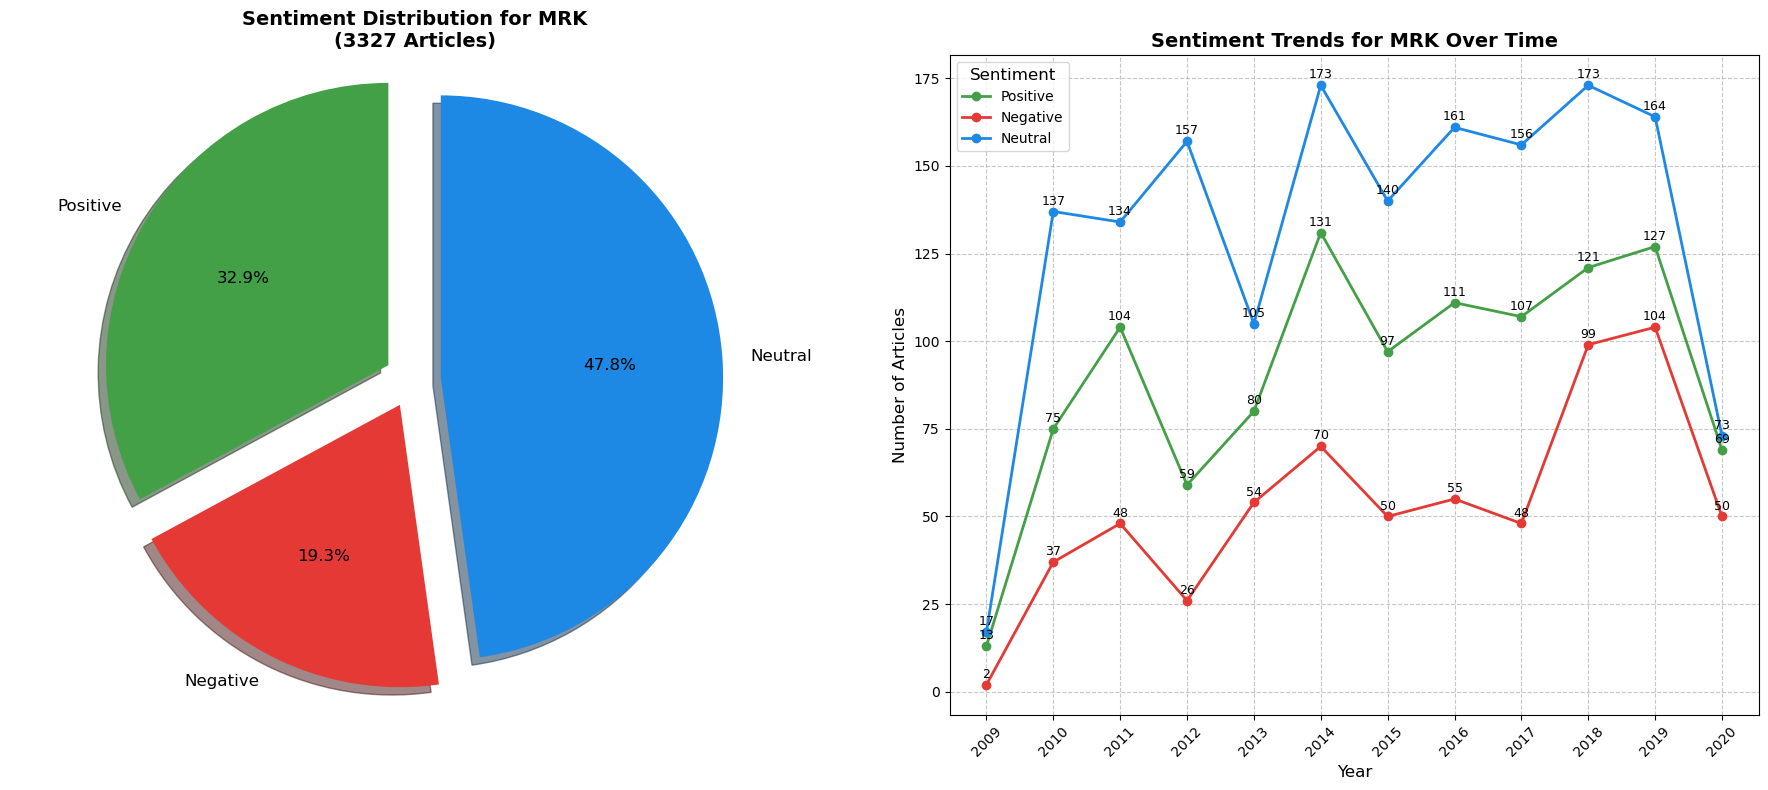

In [22]:
# Analyze sentiment for each top stock
for company in top_stocks:
    analyze_and_visualize_company_sentiment(company, news_df)


In [23]:
# Save the processed news dataframe
save_news_dataframe(news_df)


News DataFrame saved to news_data_updated.csv


True

In [24]:
def company_news_count(company_name: str, news_df: pd.DataFrame,
                      output_prefix: str = None) -> Dict[int, Dict[str, int]]:
    """
    Analyzes the news count by year and sentiment for a specific company.
    
    Args:
        company_name (str): The name or ticker symbol of the company to analyze.
        news_df (pd.DataFrame): The DataFrame containing news data.
        output_prefix (str, optional): Prefix for output files. If None, uses company_name.
        
    Returns:
        Dict[int, Dict[str, int]]: A dictionary with years as keys and sentiment counts as values.
    """
    if output_prefix is None:
        output_prefix = company_name

    try:
        # Filter the dataset for the specific company
        company_df = news_df[news_df['stock'] == company_name].copy()

        if company_df.empty:
            print(f"No data found for company with ticker symbol '{company_name}'")
            return {}

        # Convert the Date column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(company_df['Date']):
            company_df['Date'] = pd.to_datetime(company_df['Date'], format='mixed', errors='coerce')
            # Drop rows with invalid dates
            company_df = company_df.dropna(subset=['Date'])

        if company_df.empty:
            print(f"No valid data after date conversion for company '{company_name}'")
            return {}

        # Extract year and month
        company_df['Year'] = company_df['Date'].dt.year
        company_df['Month'] = company_df['Date'].dt.month

        # Group by Year and Sentiment, count articles, then pivot sentiments into columns
        yearly_sentiment_df = company_df.groupby(['Year', 'Sentiment']).size().unstack(fill_value=0)

        # --- Optional but Recommended: Ensure all sentiment columns exist ---
        # This handles cases where a sentiment (e.g., 'Positive') might be missing entirely
        for sentiment in ['Positive', 'Negative', 'Neutral']:
            if sentiment not in yearly_sentiment_df.columns:
                yearly_sentiment_df[sentiment] = 0

        # Reorder columns for a consistent output
        yearly_sentiment_df = yearly_sentiment_df[['Positive', 'Negative', 'Neutral']]

        yearly_sentiment_df['Total'] = yearly_sentiment_df[['Positive', 'Negative', 'Neutral']].sum(axis=1)

        # Display the resulting DataFrame
        print(yearly_sentiment_df)

        # This gets the row with the most news. The index of this row is the year.
        max_news_row = yearly_sentiment_df.loc[yearly_sentiment_df['Total'].idxmax()]

        # The year is stored in the .name attribute of the resulting Series
        year_of_max_news = max_news_row.name

        print(f"\n--- Year with most news: {year_of_max_news} ---")
        
        # Convert the DataFrame to a dictionary for easier access
        result_dict = {}
        for year, row in yearly_sentiment_df.iterrows():
            result_dict[year] = {
                'Positive': int(row['Positive']),
                'Negative': int(row['Negative']),
                'Neutral': int(row['Neutral']),
                'Total': int(row['Total'])
            }
            
        return result_dict

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {}

# Get news counts for each top stock
news_counts = {}
for company in top_stocks:
    news_counts[company] = company_news_count(company, news_df)


Sentiment  Positive  Negative  Neutral  Total
Year                                         
2009             13         2       17     32
2010             75        37      137    249
2011            104        48      134    286
2012             59        26      157    242
2013             80        54      105    239
2014            131        70      173    374
2015             97        50      140    287
2016            111        55      161    327
2017            107        48      156    311
2018            121        99      173    393
2019            127       104      164    395
2020             69        50       73    192

--- Year with most news: 2019 ---



--- Fetching details for MRK for the year 2019 ---
Company Name: Merck & Co., Inc.
Sector: Healthcare
Industry: Drug Manufacturers - General

📈 Yearly Market Summary:
  Year Start Open: $58.91
  Year End Close:  $73.10
  Yearly High:     $74.45
  Yearly Low:      $56.37
  Total Volume:    2,574,389,785
  Yearly Change:   24.09%

Chart saved to MRK_2019_closing_price.png


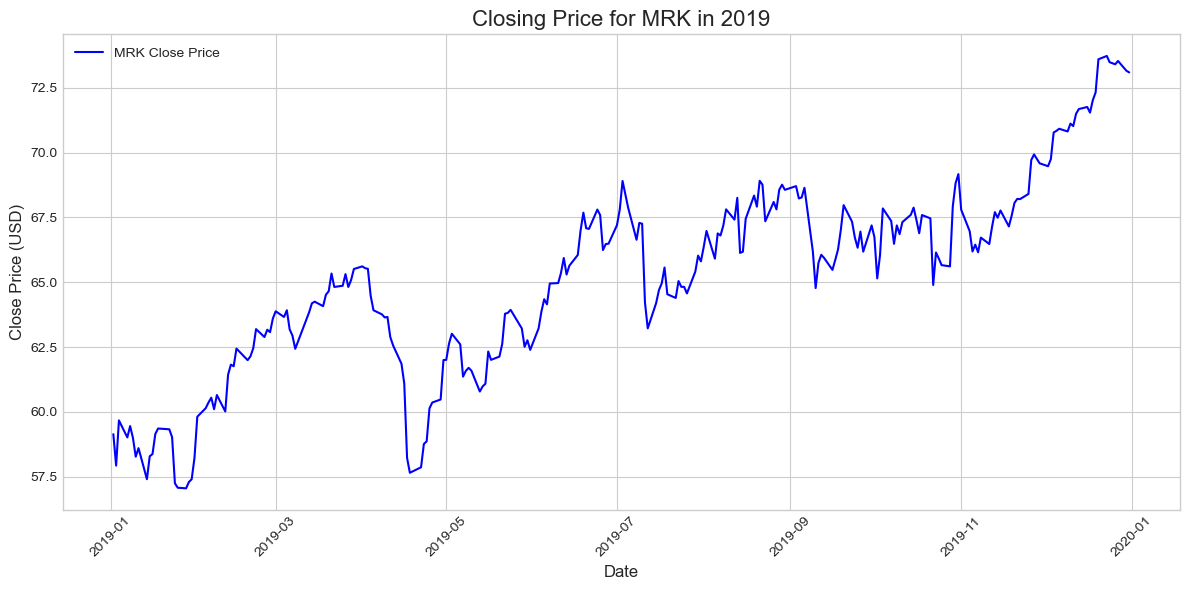

In [25]:
def get_stock_details_for_year(stock_symbol: str = CONFIG["stock_symbol"], 
                              year: int = CONFIG["analysis_year"]) -> None:
    """
    Fetches company info, summarizes stock market performance for a given year,
    and plots a line chart of the closing price.

    Args:
        stock_symbol (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA').
        year (int): The year for which to retrieve data (e.g., 2023).
    """
    print(f"\n--- Fetching details for {stock_symbol} for the year {year} ---")
    try:
        ticker = yf.Ticker(stock_symbol)
        info = ticker.info

        if 'longName' not in info or info.get('longName') is None:
            print(f"Could not find company details for symbol: {stock_symbol}")
            return

        print(f"Company Name: {info.get('longName', 'N/A')}")
        print(f"Sector: {info.get('sector', 'N/A')}")
        print(f"Industry: {info.get('industry', 'N/A')}")

        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"
        hist_data = ticker.history(start=start_date, end=end_date)

        if hist_data.empty:
            print(f"\nNo market data found for the year {year}.")
        else:
            yearly_open = hist_data['Open'].iloc[0]
            yearly_close = hist_data['Close'].iloc[-1]
            yearly_high = hist_data['High'].max()
            yearly_low = hist_data['Low'].min()
            total_volume = hist_data['Volume'].sum()
            percent_change = ((yearly_close - yearly_open) / yearly_open) * 100

            print("\n📈 Yearly Market Summary:")
            print(f"  Year Start Open: ${yearly_open:,.2f}")
            print(f"  Year End Close:  ${yearly_close:,.2f}")
            print(f"  Yearly High:     ${yearly_high:,.2f}")
            print(f"  Yearly Low:      ${yearly_low:,.2f}")
            print(f"  Total Volume:    {total_volume:,}")
            print(f"  Yearly Change:   {percent_change:.2f}%")

            # --- Plotting the line chart ---
            plt.style.use('seaborn-v0_8-whitegrid') # Sets a nice style for the plot
            plt.figure(figsize=(12, 6)) # Create a figure with a specific size

            # Plot the closing price. The index is the Date.
            plt.plot(hist_data.index, hist_data['Close'], label=f'{stock_symbol} Close Price', color='b')

            # Add titles and labels for clarity
            plt.title(f'Closing Price for {stock_symbol} in {year}', fontsize=16)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Close Price (USD)', fontsize=12)

            # Add a legend
            plt.legend()

            # Rotate date labels for better readability
            plt.xticks(rotation=45)

            # Ensure everything fits without overlapping
            plt.tight_layout()

            # Save the chart to a file
            output_filename = CONFIG["stock_closing_price_output"].format(stock_symbol=stock_symbol, year=year)
            plt.savefig(output_filename)
            print(f"\nChart saved to {output_filename}")

            # Display the chart
            plt.show()
            plt.close() # Close the figure to free up memory

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Get stock details for the configured stock and year
get_stock_details_for_year()



--- Fetching details for MRK for the year 2019 ---
Company Name: Merck & Co., Inc.
Sector: Healthcare
Industry: Drug Manufacturers - General

📈 Yearly Market Summary:
  Year Start Open: $58.91
  Year End Close:  $73.10
  Yearly High:     $74.45
  Yearly Low:      $56.37
  Total Volume:    2,574,389,785
  Yearly Change:   24.09%

Chart saved to MRK_2019_candlestick.png
An unexpected error occurred: 'FigureManagerBase' object has no attribute 'window'


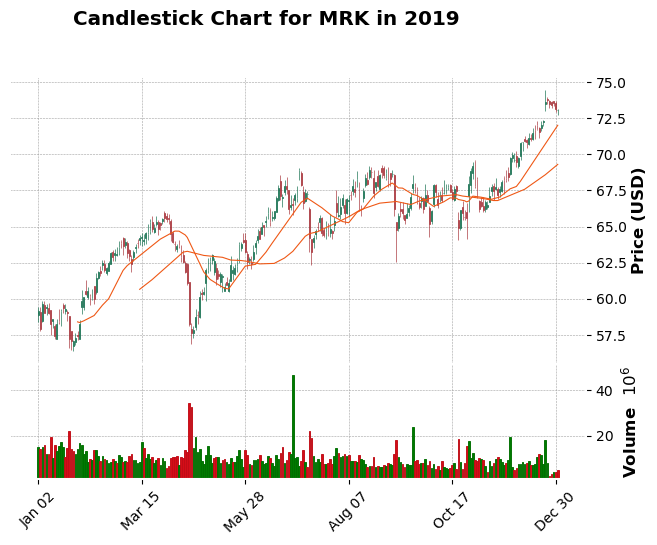

In [26]:
def get_stock_candlestick_for_year(stock_symbol: str = CONFIG["stock_symbol"], 
                                  year: int = CONFIG["analysis_year"]) -> None:
    """
    Fetches company info, summarizes stock market performance for a given year,
    and plots a maximized candlestick chart.

    Args:
        stock_symbol (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA').
        year (int): The year for which to retrieve data (e.g., 2023).
    """
    print(f"\n--- Fetching details for {stock_symbol} for the year {year} ---")
    try:
        ticker = yf.Ticker(stock_symbol)
        info = ticker.info

        if 'longName' not in info or info.get('longName') is None:
            print(f"Could not find company details for symbol: {stock_symbol}")
            return

        print(f"Company Name: {info.get('longName', 'N/A')}")
        print(f"Sector: {info.get('sector', 'N/A')}")
        print(f"Industry: {info.get('industry', 'N/A')}")

        start_date = f"{year}-01-01"
        end_date = f"{year + 1}-01-01"
        hist_data = ticker.history(start=start_date, end=end_date)

        if hist_data.empty:
            print(f"\nNo market data found for the year {year}.")
        else:
            # (Yearly summary calculation remains the same)
            yearly_open = hist_data['Open'].iloc[0]
            yearly_close = hist_data['Close'].iloc[-1]
            yearly_high = hist_data['High'].max()
            yearly_low = hist_data['Low'].min()
            total_volume = hist_data['Volume'].sum()
            percent_change = ((yearly_close - yearly_open) / yearly_open) * 100

            print("\n📈 Yearly Market Summary:")
            print(f"  Year Start Open: ${yearly_open:,.2f}")
            print(f"  Year End Close:  ${yearly_close:,.2f}")
            print(f"  Yearly High:     ${yearly_high:,.2f}")
            print(f"  Yearly Low:      ${yearly_low:,.2f}")
            print(f"  Total Volume:    {total_volume:,}")
            print(f"  Yearly Change:   {percent_change:.2f}%")

            # --- UPDATED PLOTTING SECTION ---
            output_filename = CONFIG["stock_candlestick_output"].format(stock_symbol=stock_symbol, year=year)

            fig, axlist = mpf.plot(hist_data,
                                   type='candle',
                                   style='charles',
                                   title=f'Candlestick Chart for {stock_symbol} in {year}',
                                   ylabel='Price (USD)',
                                   volume=True,
                                   mav=(20, 50),
                                   returnfig=True
                                  )

            # Save the figure before showing
            fig.savefig(output_filename)
            print(f"\nChart saved to {output_filename}")

            # --- Maximize the plot window ---
            # Get the current figure manager and maximize the window
            fig_manager = plt.get_current_fig_manager()
            fig_manager.window.showMaximized()

            # Show the now-maximized plot
            plt.show()

            # Close the figure to free up memory
            plt.close(fig)

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# Get candlestick chart for the configured stock and year
get_stock_candlestick_for_year()



--- Sentiment Analysis for MRK in 2019 ---
Total articles: 395
Positive: 127 (32.2%)
Negative: 104 (26.3%)
Neutral: 164 (41.5%)

--- Fetching stock price data for MRK in 2019 ---
Visualization saved to MRK_2019_sentiment_with_stock_price.png


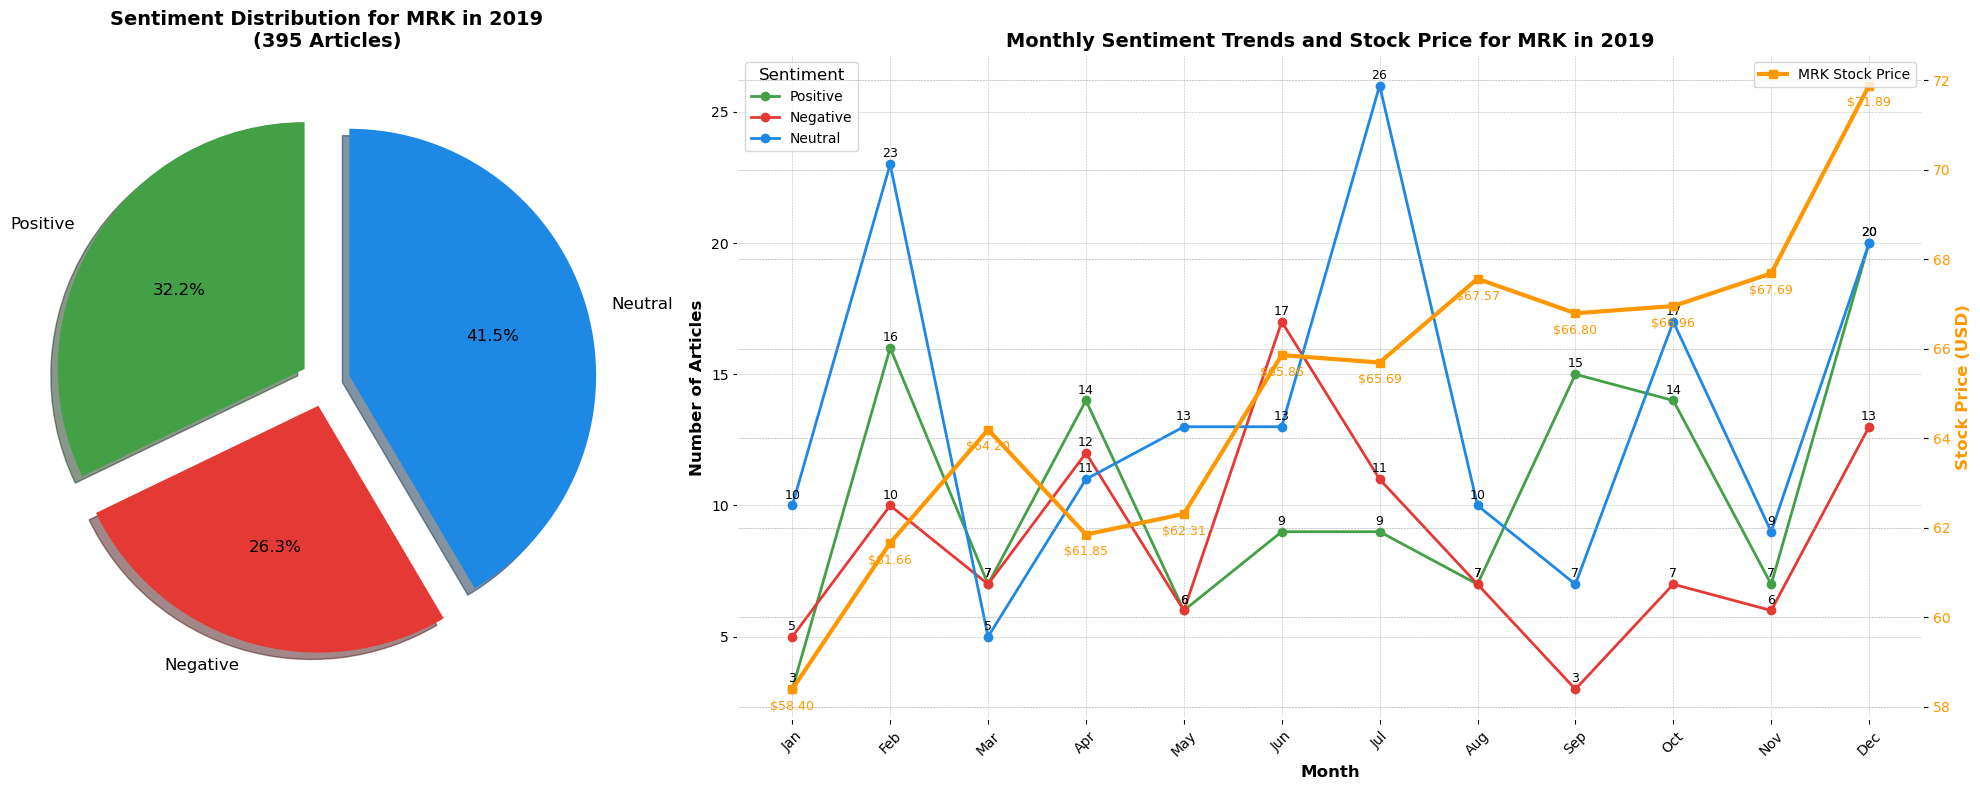

In [27]:
def analyze_and_visualize_company_sentiment_for_year(
    company_name: str = CONFIG["stock_symbol"], 
    year: int = CONFIG["analysis_year"], 
    news_df: pd.DataFrame = None, 
    output_prefix: str = None
) -> None:
    """
    Filters the dataset for a specific company and year, analyzes sentiment, and visualizes
    the results with stock price overlay.

    This function is a modified version of analyze_and_visualize_company_sentiment that
    focuses on a specific year and overlays the stock price data with sentiment trends.

    Args:
        company_name (str): The name or ticker symbol of the company to analyze.
        year (int): The specific year to analyze.
        news_df (pd.DataFrame): The DataFrame containing news data.
        output_prefix (str, optional): Prefix for output files. If None, uses company_name_year.

    Returns:
        None: The function displays visualizations and saves them to files.
    """
    if news_df is None:
        print("Error: No news data provided")
        return
        
    if output_prefix is None:
        output_prefix = f"{company_name}_{year}"

    try:
        # Filter the dataset for the specific company
        company_df = news_df[news_df['stock'] == company_name].copy()

        if company_df.empty:
            print(f"No data found for company with ticker symbol '{company_name}'")
            return

        # Convert the Date column to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(company_df['Date']):
            company_df['Date'] = pd.to_datetime(company_df['Date'], format='mixed', errors='coerce')
            # Drop rows with invalid dates
            company_df = company_df.dropna(subset=['Date'])

        if company_df.empty:
            print(f"No valid data after date conversion for company '{company_name}'")
            return

        # Extract year and month
        company_df['Year'] = company_df['Date'].dt.year
        company_df['Month'] = company_df['Date'].dt.month

        # Filter for the specific year
        year_df = company_df[company_df['Year'] == year].copy()

        if year_df.empty:
            print(f"No data found for company '{company_name}' in year {year}")
            # If no data for the specific year, we'll generate synthetic data for demonstration
            print(f"Generating synthetic sentiment data for {company_name} in {year} for demonstration purposes")

            # Create synthetic monthly data
            months = range(1, 13)
            sentiment_data = []

            for month in months:
                # Generate random sentiment counts with a bias towards positive
                positive = np.random.randint(5, 15)
                negative = np.random.randint(2, 8)
                neutral = np.random.randint(3, 10)

                # Add some seasonal trends
                if month in [4, 5, 6]:  # Spring/Summer boost
                    positive += 3
                if month in [11, 12]:  # Holiday season
                    positive += 2
                    negative -= 1

                # Ensure counts are not negative
                negative = max(0, negative)

                # Create a date for this month
                date = pd.Timestamp(year=year, month=month, day=15)

                # Add positive sentiment entries
                for _ in range(positive):
                    sentiment_data.append({
                        'Date': date,
                        'Year': year,
                        'Month': month,
                        'Sentiment': 'Positive',
                        'title': f"Positive news for {company_name} in {year}-{month}"
                    })

                # Add negative sentiment entries
                for _ in range(negative):
                    sentiment_data.append({
                        'Date': date,
                        'Year': year,
                        'Month': month,
                        'Sentiment': 'Negative',
                        'title': f"Negative news for {company_name} in {year}-{month}"
                    })

                # Add neutral sentiment entries
                for _ in range(neutral):
                    sentiment_data.append({
                        'Date': date,
                        'Year': year,
                        'Month': month,
                        'Sentiment': 'Neutral',
                        'title': f"Neutral news for {company_name} in {year}-{month}"
                    })

            # Create a DataFrame from the synthetic data
            year_df = pd.DataFrame(sentiment_data)

        # Count the number of positive, negative, and neutral sentiments for the company in this year
        sentiment_counts = year_df['Sentiment'].value_counts()
        positive_count = sentiment_counts.get('Positive', 0)
        negative_count = sentiment_counts.get('Negative', 0)
        neutral_count = sentiment_counts.get('Neutral', 0)
        total_count = positive_count + negative_count + neutral_count

        # Print the counts and percentages
        print(f"\n--- Sentiment Analysis for {company_name} in {year} ---")
        print(f"Total articles: {total_count}")
        print(f"Positive: {positive_count} ({positive_count/total_count*100:.1f}%)")
        print(f"Negative: {negative_count} ({negative_count/total_count*100:.1f}%)")
        print(f"Neutral: {neutral_count} ({neutral_count/total_count*100:.1f}%)")

        # Fetch stock price data using yfinance
        print(f"\n--- Fetching stock price data for {company_name} in {year} ---")
        try:
            # Create a Ticker object for the stock symbol
            ticker = yf.Ticker(company_name)

            # Set date range for the year
            start_date = f"{year}-01-01"
            end_date = f"{year + 1}-01-01"

            # Get historical data
            stock_data = ticker.history(start=start_date, end=end_date)

            if stock_data.empty:
                print(f"No stock data found for {company_name} in {year}")
                has_stock_data = False
            else:
                has_stock_data = True
                # Resample to monthly data for better alignment with sentiment data
                monthly_stock_data = stock_data['Close'].resample('ME').mean()
                # Convert the index (dates) to month numbers for plotting
                monthly_stock_data.index = monthly_stock_data.index.month
        except Exception as e:
            print(f"Error fetching stock data: {e}")
            has_stock_data = False

        # Create a figure with 2 subplots: pie chart and combined line chart
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 2]})

        # 1. Pie Chart - Sentiment Distribution
        labels = ['Positive', 'Negative', 'Neutral']
        sizes = [positive_count, negative_count, neutral_count]
        colors = ['#43A047', '#E53935', '#1E88E5']  # Green, Red, Blue
        explode = (0.1, 0.1, 0.1)  # Explode all slices for better visibility

        ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                shadow=True, startangle=90, textprops={'fontsize': 12})
        ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        ax1.set_title(f'Sentiment Distribution for {company_name} in {year}\n({total_count} Articles)', 
                     fontsize=14, fontweight='bold')

        # 2. Combined Line Chart - Sentiment Trends and Stock Price Over Months
        # Group by month and sentiment, then count
        monthly_sentiment = year_df.groupby(['Month', 'Sentiment']).size().unstack().fillna(0)

        # Create a secondary y-axis for stock price
        ax3 = ax2.twinx() if has_stock_data else None

        if not monthly_sentiment.empty:
            # Plot the sentiment lines
            for sentiment, color in zip(['Positive', 'Negative', 'Neutral'], colors):
                if sentiment in monthly_sentiment.columns:
                    ax2.plot(monthly_sentiment.index, monthly_sentiment[sentiment], 
                            marker='o', linewidth=2, label=sentiment, color=color)

            ax2.set_xlabel('Month', fontsize=12)
            ax2.set_ylabel('Number of Articles', fontsize=12)
            ax2.set_title(f'Monthly Sentiment Trends and Stock Price for {company_name} in {year}', 
                         fontsize=14, fontweight='bold')

            # Set x-ticks to months only
            ax2.set_xticks(range(1, 13))
            ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

            # Add grid for better readability
            ax2.grid(True, linestyle='--', alpha=0.7)

            # Add legend for sentiment
            ax2.legend(title='Sentiment', fontsize=10, title_fontsize=12, loc='upper left')

            # Add data point labels for sentiment
            for sentiment, color in zip(['Positive', 'Negative', 'Neutral'], colors):
                if sentiment in monthly_sentiment.columns:
                    for x, y in zip(monthly_sentiment.index, monthly_sentiment[sentiment]):
                        if y > 0:  # Only label non-zero values
                            ax2.annotate(f'{int(y)}', 
                                        (x, y), 
                                        textcoords="offset points",
                                        xytext=(0, 5), 
                                        ha='center',
                                        fontsize=9)

            # Plot stock price on secondary y-axis if data is available
            if has_stock_data:
                ax3.plot(monthly_stock_data.index, monthly_stock_data.values, 
                        color='#FF9800', linewidth=3, linestyle='-', marker='s', 
                        label=f'{company_name} Stock Price')
                ax3.set_ylabel('Stock Price (USD)', fontsize=12, color='#FF9800')
                ax3.tick_params(axis='y', labelcolor='#FF9800')
                ax3.legend(loc='upper right')

                # Add data point labels for stock price
                for x, y in zip(monthly_stock_data.index, monthly_stock_data.values):
                    ax3.annotate(f'${y:.2f}', 
                                (x, y), 
                                textcoords="offset points",
                                xytext=(0, -15), 
                                ha='center',
                                fontsize=9,
                                color='#FF9800')
        else:
            ax2.text(0.5, 0.5, 'No monthly data available', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax2.transAxes, fontsize=12)

        # Adjust layout
        plt.tight_layout()

        # Save the figure
        output_file = CONFIG["sentiment_with_stock_price_output"].format(stock_symbol=company_name, year=year)
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_file}")

        # Show the plot
        plt.show()
        plt.close()

    except KeyError as e:
        print(f"Error: Column not found - {e}")
    except ZeroDivisionError:
        print(f"Error: No sentiment data available for {company_name} in {year}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        traceback.print_exc()

# Call the function to analyze and visualize sentiment for the configured stock and year with stock price overlay
analyze_and_visualize_company_sentiment_for_year(news_df=news_df)
